<a href="https://www.kaggle.com/code/devasypatel23/face-rec-trail-on-indian-faces?scriptVersionId=189185196" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indian-faces-image-classification/Image_Test/MEGHANA/MEGHANA_17.jpeg
/kaggle/input/indian-faces-image-classification/Image_Test/MEGHANA/MEGHANA_19.jpeg
/kaggle/input/indian-faces-image-classification/Image_Test/MEGHANA/MEGHANA_18.jpeg
/kaggle/input/indian-faces-image-classification/Image_Test/MEGHANA/MEGHANA_16.jpeg
/kaggle/input/indian-faces-image-classification/Image_Test/MEGHANA/MEGHANA_20.jpeg
/kaggle/input/indian-faces-image-classification/Image_Test/MEGHANA/MEGHANA_15.jpeg
/kaggle/input/indian-faces-image-classification/Image_Test/Aisvarrya/Aisvarrya_18.jpeg
/kaggle/input/indian-faces-image-classification/Image_Test/Aisvarrya/Aisvarrya_17.jpeg
/kaggle/input/indian-faces-image-classification/Image_Test/Aisvarrya/Aisvarrya_20.jpeg
/kaggle/input/indian-faces-image-classification/Image_Test/Aisvarrya/Aisvarrya_15.jpeg
/kaggle/input/indian-faces-image-classification/Image_Test/Aisvarrya/Aisvarrya_19.jpeg
/kaggle/input/indian-faces-image-classification/Image_Test/Aisvarry

In [2]:
!pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.5/105.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 58.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.0 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117031 sha256=cfc7ebc1084f04a5047b0ae16036ffac1f18c1cc796787d89c292defd4505317
  Stored in directory: /root/.cache/pip/wheels/d6/6d/5d/5b73fa0f46d01a793713f8859201361e9e581ced8c75e5c6a3
Successfully built fire
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the so

In [3]:
import os
import shutil

count = 0
path = "/kaggle/input/indian-faces-image-classification/Image_Train"
for folder in os.listdir(path):
    if len(os.listdir(f"{path}/{folder}")) < 5:
        shutil.rmtree(f"{path}/{folder}")
        count += 1
print(f"Removed {count} folders")
print(f"Remaining folders: {len(os.listdir(path))}")

Removed 0 folders
Remaining folders: 16


In [23]:
import os
import numpy as np
from tqdm import tqdm_notebook
from keras.models import load_model
from keras.preprocessing import image
from sklearn.metrics.pairwise import euclidean_distances
from deepface import DeepFace
import tensorflow as tf
import cv2


# Function to load and preprocess images
def load_and_preprocess_image(img_path, target_size=(160, 160), extract=False):

    if extract:
        img_array = DeepFace.extract_faces(img_path, enforce_detection=False)[0]["face"]
        img_array = cv2.resize(img_array, target_size, interpolation=cv2.INTER_AREA)
    else:
        img = image.load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array


# Function to generate embeddings
def generate_embeddings(model, dataset_path, deepface=False):
    embeddings = {}

    for class_name in tqdm_notebook(os.listdir(dataset_path)):
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_path):
            continue
        embeddings[class_name] = []

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img_array = load_and_preprocess_image(img_path, extract=True)
            if deepface:
                embedding = DeepFace.represent(
                    img_path=img_path, model_name="Facenet512", enforce_detection=False
                )[0]["embedding"]
            else:
                embedding = model.predict(img_array, verbose=0)
            embeddings[class_name].append(embedding)
        embeddings[class_name] = np.array(embeddings[class_name])

    return embeddings


# Function to calculate intra-cluster distances
def calculate_intra_cluster_metrics(embeddings):
    metrics = {}

    for label, cluster_embeddings in embeddings.items():
        cluster_embeddings = np.squeeze(cluster_embeddings, axis=1)

        avg_embedding = np.mean(cluster_embeddings, axis=0)
        distances = euclidean_distances(cluster_embeddings, [avg_embedding])
        max_distance = np.max(distances)
        min_distance = np.min(distances)
        variance = np.var(distances)
        standard_deviation = np.std(distances)
        percentile_25 = np.percentile(distances, 25)
        percentile_50 = np.percentile(distances, 50)
        percentile_75 = np.percentile(distances, 75)

        metrics[label] = {
            "center": avg_embedding,
            "max_radius": max_distance,
            "min_radius": min_distance,
            "num_samples": len(cluster_embeddings),
            "variance": variance,
            "standard_deviation": standard_deviation,
            "percentile_25": percentile_25,
            "percentile_50": percentile_50,
            "percentile_75": percentile_75,
        }

    return metrics

In [5]:
# Path to the dataset
dataset_path = "/kaggle/input/indian-faces-image-classification/Image_Train"
model = 1
# Generate embeddings for the original model
embeddings_original = generate_embeddings(model, dataset_path, True)

  0%|          | 0/16 [00:00<?, ?it/s]

24-07-21 14:26:11 - facenet512_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet512_weights.h5
To: /root/.deepface/weights/facenet512_weights.h5

  0%|          | 0.00/95.0M [00:00<?, ?B/s]
 30%|███       | 28.8M/95.0M [00:00<00:00, 288MB/s]
100%|██████████| 95.0M/95.0M [00:00<00:00, 419MB/s]


In [6]:
!wget https://huggingface.co/DnD11/FaceNet_Finetuned/resolve/main/embedding_trial2.h5

--2024-07-21 14:27:31--  https://huggingface.co/DnD11/FaceNet_Finetuned/resolve/main/embedding_trial2.h5
Resolving huggingface.co (huggingface.co)... 3.163.189.37, 3.163.189.90, 3.163.189.74, ...
Connecting to huggingface.co (huggingface.co)|3.163.189.37|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/03/4f/034f80180b5ba08a0d9fe97aa18e17eb02604e9ba5c3e985eaee5a613e4810f6/901871f1a8502c1e168ce190908e8c5658f350ab7f0626932ab6cea57f67c9be?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27embedding_trial2.h5%3B+filename%3D%22embedding_trial2.h5%22%3B&Expires=1721831251&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMTgzMTI1MX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzAzLzRmLzAzNGY4MDE4MGI1YmEwOGEwZDlmZTk3YWExOGUxN2ViMDI2MDRlOWJhNWMzZTk4NWVhZWU1YTYxM2U0ODEwZjYvOTAxODcxZjFhODUwMmMxZTE2OGNlMTkwOTA4ZThjNTY1OGYzNTBhYjdmMDYyNjkzMmFiNmNlY

In [20]:
# Load the fine-tuned model
import tensorflow as tf

finetuned_model = tf.keras.models.load_model("/kaggle/working/embedding_trial2.h5")
embeddings_finetuned = generate_embeddings(finetuned_model, dataset_path)

  0%|          | 0/16 [00:00<?, ?it/s]

In [22]:
# Calculate intra-cluster distances for both models
metrics_original = calculate_intra_cluster_metrics(embeddings_original)
#

In [24]:
metrics_finetuned = calculate_intra_cluster_metrics(embeddings_finetuned)

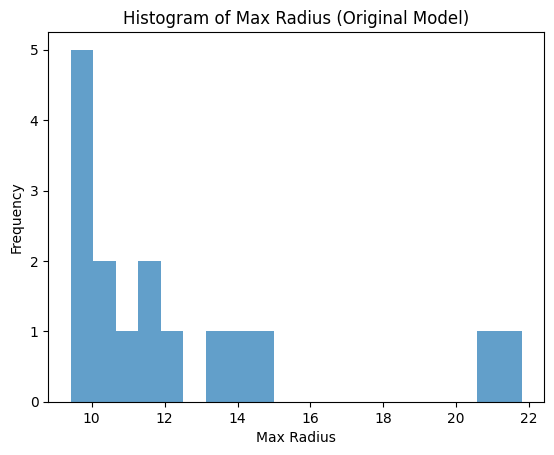

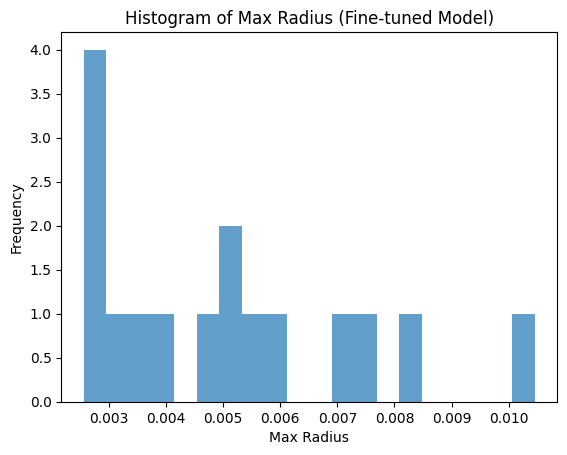

In [25]:
import matplotlib.pyplot as plt


def plot_histogram(metrics, key, title, xlabel):
    values = [metrics[label][key] for label in metrics]
    plt.figure()
    plt.hist(values, bins=20, alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.show()


plot_histogram(
    metrics_original,
    "max_radius",
    "Histogram of Max Radius (Original Model)",
    "Max Radius",
)
plot_histogram(
    metrics_finetuned,
    "max_radius",
    "Histogram of Max Radius (Fine-tuned Model)",
    "Max Radius",
)

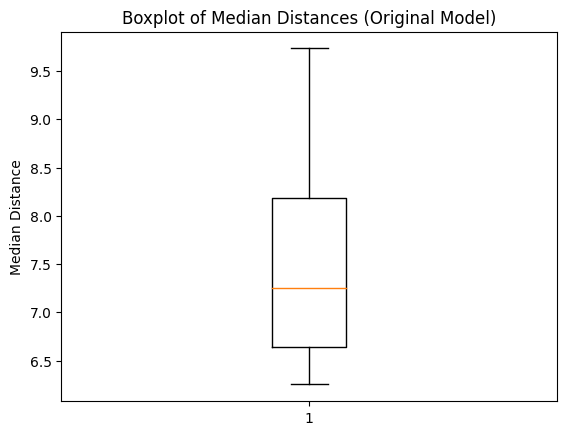

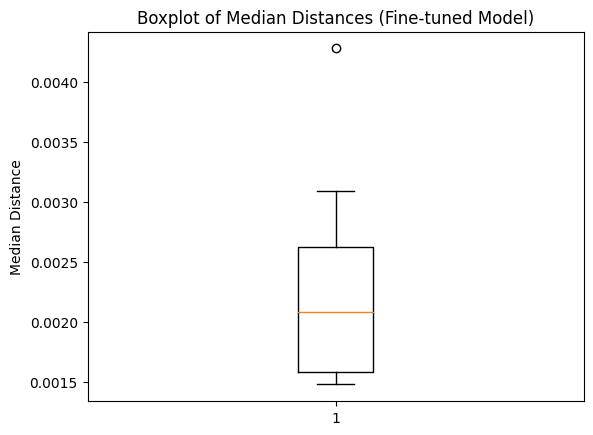

In [26]:
def plot_boxplot(metrics, key, title, ylabel):
    values = [metrics[label][key] for label in metrics]
    plt.figure()
    plt.boxplot(values)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.show()


plot_boxplot(
    metrics_original,
    "percentile_50",
    "Boxplot of Median Distances (Original Model)",
    "Median Distance",
)
plot_boxplot(
    metrics_finetuned,
    "percentile_50",
    "Boxplot of Median Distances (Fine-tuned Model)",
    "Median Distance",
)

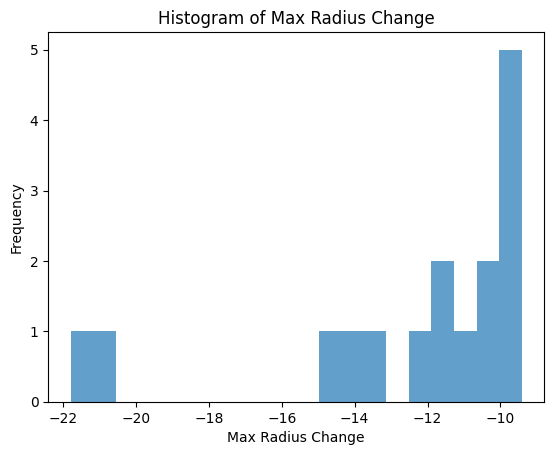

In [27]:
import matplotlib.pyplot as plt


def plot_histogram(metrics, title, xlabel):
    values = list(metrics.values())  # Extract values from the dictionary
    plt.figure()
    plt.hist(values, bins=20, alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.show()


def compare_metrics(metrics_original, metrics_finetuned, key):
    changes = {}
    for label in metrics_original:
        if label in metrics_finetuned:
            change = metrics_finetuned[label][key] - metrics_original[label][key]
            changes[label] = change
    return changes


max_radius_change = compare_metrics(metrics_original, metrics_finetuned, "max_radius")
plot_histogram(max_radius_change, "Histogram of Max Radius Change", "Max Radius Change")

In [28]:
def calculate_inter_cluster_metrics(embeddings):
    centers = {label: metrics["center"] for label, metrics in embeddings.items()}
    labels = list(centers.keys())
    inter_cluster_distances = euclidean_distances(list(centers.values()))

    metrics = {}
    for i, label1 in enumerate(labels):
        for j, label2 in enumerate(labels):
            if i >= j:
                continue
            distance = inter_cluster_distances[i, j]
            pair = tuple(sorted((label1, label2)))
            metrics[pair] = distance

    return metrics


inter_cluster_metrics_original = calculate_inter_cluster_metrics(metrics_original)
inter_cluster_metrics_finetuned = calculate_inter_cluster_metrics(metrics_finetuned)

In [ ]:
inter_cluster_metrics_original

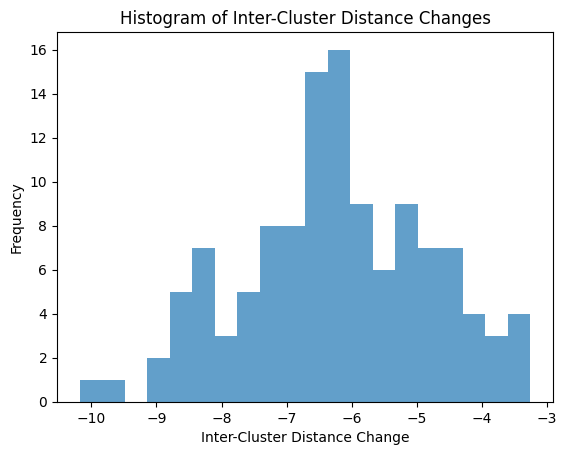

In [29]:
def compare_inter_cluster_metrics(metrics_original, metrics_finetuned):
    changes = {}
    for pair in metrics_original:
        if pair in metrics_finetuned:
            change = metrics_finetuned[pair] - metrics_original[pair]
            changes[pair] = change
    return changes


inter_cluster_distance_change = compare_inter_cluster_metrics(
    inter_cluster_metrics_original, inter_cluster_metrics_finetuned
)


def plot_inter_cluster_changes(inter_cluster_distance_change, title, xlabel):
    values = list(inter_cluster_distance_change.values())
    plt.figure()
    plt.hist(values, bins=20, alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.show()


plot_inter_cluster_changes(
    inter_cluster_distance_change,
    "Histogram of Inter-Cluster Distance Changes",
    "Inter-Cluster Distance Change",
)

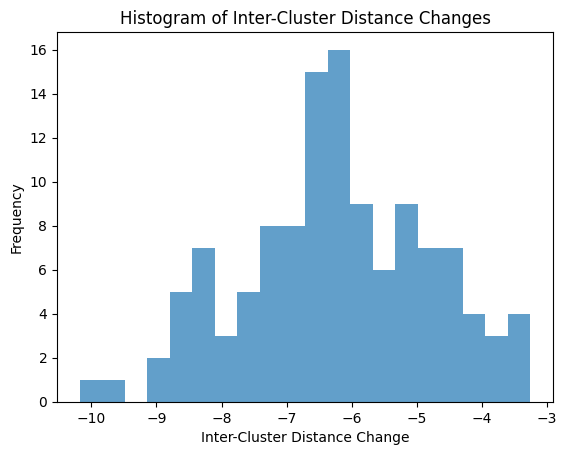

In [30]:
def compare_inter_cluster_metrics(metrics_original, metrics_finetuned):
    changes = {}
    for pair in metrics_original:
        if pair in metrics_finetuned:
            change = metrics_finetuned[pair] - metrics_original[pair]
            changes[pair] = change
    return changes


inter_cluster_distance_change = compare_inter_cluster_metrics(
    inter_cluster_metrics_original, inter_cluster_metrics_finetuned
)


def plot_inter_cluster_changes(inter_cluster_distance_change, title, xlabel):
    values = list(inter_cluster_distance_change.values())
    plt.figure()
    plt.hist(values, bins=20, alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.show()


plot_inter_cluster_changes(
    inter_cluster_distance_change,
    "Histogram of Inter-Cluster Distance Changes",
    "Inter-Cluster Distance Change",
)

In [31]:
def classify_impact(
    intra_metrics_original,
    intra_metrics_finetuned,
    inter_metrics_original,
    inter_metrics_finetuned,
):
    impact = {
        "positively_impacted": [],
        "negatively_impacted": [],
        "averagely_impacted": [],
    }

    # Define thresholds for considering a change as significant
    threshold = 0.01  # You can adjust this value based on your needs

    # Classify intra-cluster metric changes
    for label in intra_metrics_original:
        if label in intra_metrics_finetuned:
            max_radius_change = (
                intra_metrics_finetuned[label]["max_radius"]
                - intra_metrics_original[label]["max_radius"]
            )
            if max_radius_change < -threshold:
                impact["positively_impacted"].append((label, "max_radius"))
            elif max_radius_change > threshold:
                impact["negatively_impacted"].append((label, "max_radius"))
            else:
                impact["averagely_impacted"].append((label, "max_radius"))

            # Add other metrics here if needed
            # Example: variance, standard_deviation, etc.
            variance_change = (
                intra_metrics_finetuned[label]["variance"]
                - intra_metrics_original[label]["variance"]
            )
            if variance_change < -threshold:
                impact["positively_impacted"].append((label, "variance"))
            elif variance_change > threshold:
                impact["negatively_impacted"].append((label, "variance"))
            else:
                impact["averagely_impacted"].append((label, "variance"))

    # Classify inter-cluster metric changes
    for pair in inter_metrics_original:
        if pair in inter_metrics_finetuned:
            distance_change = (
                inter_metrics_finetuned[pair] - inter_metrics_original[pair]
            )
            if distance_change < -threshold:
                impact["positively_impacted"].append((pair, "inter_cluster_distance"))
            elif distance_change > threshold:
                impact["negatively_impacted"].append((pair, "inter_cluster_distance"))
            else:
                impact["averagely_impacted"].append((pair, "inter_cluster_distance"))

    return impact


# Assuming metrics_original and metrics_finetuned are dictionaries containing the calculated metrics
impact = classify_impact(
    metrics_original,
    metrics_finetuned,
    inter_cluster_metrics_original,
    inter_cluster_metrics_finetuned,
)

# Print the impact classification
print(f"Positively Impacted Faces: {len(impact['positively_impacted'])}")
print(f"Negatively Impacted Faces: {len(impact['negatively_impacted'])}")
print(f"Averagely Impacted Faces: {len(impact['averagely_impacted'])}")

Positively Impacted Faces: 152
Negatively Impacted Faces: 0
Averagely Impacted Faces: 0
